# Bore information

This example notebook describes how to retrieve data for a small region and epoch of interest, concatenate data from available sensors and calculate the annual mean NDVI values.  You can then select a location of interest based on the change between years, retrieve an NDVI time series for that location and select imagery from before and after the change event

In [1]:
%pylab notebook
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
import datetime
import rasterio
import pandas as pd
import numpy as np
from pyproj import Proj, transform
from datacube.storage.storage import write_dataset_to_netcdf
from dateutil import tz
import csv
import rasterio
from_zone = tz.tzutc()
to_zone = tz.tzlocal()
from datacube.storage.storage import write_dataset_to_netcdf

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Insert the ID code for the gauge of interest. e.g. for 'Diamantina River at Birdsville' the ID code is 'A0020101'

bore_of_interest= 'RN010167'

In [3]:
dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

In [4]:
##Load in the coordinates for the gauge_of_interest
#input location spreadsheet
coordinates_of_interest= all_data= pd.read_csv('/g/data/r78/Geohack/Input/4_bore/Bore_Detailed.csv')
coordinates_of_interest=coordinates_of_interest.set_index('Bore ID').loc[bore_of_interest]

#return long and lat
sg_lon=coordinates_of_interest.Longitude
sg_lat=coordinates_of_interest.Latitude

#reproject
inProj = Proj(init='EPSG:4326')
outProj = Proj(init='EPSG:3577')
sg_x,sg_y = transform(inProj,outProj,sg_lon,sg_lat)

print "GDA 1994"
print sg_lon
print sg_lat
print ""
print "Australian Albers"
print sg_x
print sg_y

GDA 1994
134.061
-19.803

Australian Albers
215034.256199
-2123928.84306


In [5]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Either as polygon or as lat/lon range

#Define temporal range
start_of_epoch = '1987-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2014-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest, # out sensors that aren't relevant for the time period
sensors = [
    'ls8', #May 2013 to present
    'ls7', #1999 to present
    'ls5' #1986 to 2011, full contintal coverage from 1987 onwards
        ] 


query = {
    'time': (start_of_epoch, end_of_epoch),
}


lat_max = sg_lat + 0.05
lat_min = sg_lat - 0.05
lon_max = sg_lon + 0.05
lon_min = sg_lon - 0.05


query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [6]:
print query

{'y': (-19.753, -19.853000000000002), 'x': (134.011, 134.11100000000002), 'crs': 'EPSG:4326', 'time': ('1987-01-01', '2014-12-31')}


## PQ and Index preparation


In [7]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensors[0]+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [8]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [9]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
    #grab the projection info before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    #This line is to make sure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    #Apply the PQ masks to the NBAR
    cloud_free = masking.make_mask(sensor_pq, **mask_components)
    good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar = sensor_nbar.where(good_data)
    sensor_clean[sensor] = sensor_nbar

In [10]:
sensor_nbar

<xarray.Dataset>
Dimensions:  (time: 567, x: 425, y: 452)
Coordinates:
  * time     (time) datetime64[ns] 1987-05-25T00:30:42.500000 ...
  * y        (y) float64 -2.118e+06 -2.118e+06 -2.118e+06 -2.118e+06 ...
  * x        (x) float64 2.097e+05 2.098e+05 2.098e+05 2.098e+05 2.098e+05 ...
Data variables:
    green    (time, y, x) float64 1.057e+03 1.006e+03 1.057e+03 1.108e+03 ...
    red      (time, y, x) float64 1.958e+03 2.004e+03 2.004e+03 1.958e+03 ...
    nir      (time, y, x) float64 2.698e+03 2.754e+03 2.809e+03 2.809e+03 ...
    swir1    (time, y, x) float64 4.116e+03 4.116e+03 4.116e+03 3.997e+03 ...
Attributes:
    crs: EPSG:3577

In [11]:
#Concatenate data from different sensors together and sort so that observations are sorted by time rather
# than sensor
nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

## Import and process stream gauge information

In [12]:
#import all streamflow data and delete "local" column
all_data= pd.read_csv('/g/data/r78/Geohack/Input/4_bore/'+bore_of_interest+'.csv')
all_data['order']= np.arange(len(all_data)) + 1
    #sort data by flow
all_data = all_data.sort_values('Result (m)', ascending=[False])
    #create rank column and data
all_data['ranks'] = np.arange(len(all_data)) + 1
    # calculate probability of each rank
all_data['perexc'] = 100*(all_data['ranks'])/(len(all_data)+1)
all_data = all_data.sort_values(['order'])
all_data=all_data.drop(all_data.columns[[2]], axis=1)
all_data['Date']=pd.to_datetime(all_data['Date'], format= '%Y-%m-%d %H:%M:%S')
#all_data['Date']=pd.to_datetime(all_data['Date'], format= '%Y-%m-%d')
#all_data.date=.datetime.strftime('%Y-%m-%d', all_data.date)
all_data.to_csv('/g/data/r78//Geohack/Input/4_bore/'+bore_of_interest+'_PE.csv')


In [13]:
#Run script to match streamgauge with satellite observations at gauge location
#Script based on one created by Biswajit Bala

input_file = '/g/data/r78/Geohack/Input/4_bore/'+ bore_of_interest +'_PE.csv'
output_file = '/g/data/r78/Geohack/Input/4_bore/'+ bore_of_interest+'_matched.csv'

dc=datacube.Datacube(app='GW_map')
acq_min="01-01-1986"
acq_max="31-12-2014"
prod=['ls5', 'ls7', 'ls8']
#prod=['ls5']
date_list = list()

##Load in the coordinates for the gauge_of_interest

indexers ={'time':(acq_min, acq_max), 'x':((sg_lon-0.05), (sg_lon+0.05)), 'y':((sg_lat-0.05), (sg_lat+0.05))}

for pr in prod:
    if pr == 'ls5':
        bb = 'ls5_pq_albers'
    if pr == 'ls7':
        bb = 'ls7_pq_albers'
    if pr == 'ls8':
        bb = 'ls8_pq_albers'

    print ("loading datasets for " + pr)    
    data = dc.load(product=bb, **indexers)
    data = data.time.data
    for x in data:                                                                                    
         utc=datetime.datetime.strptime(str(x)[:19], '%Y-%m-%dT%H:%M:%S')                                       
         utc = utc.replace(tzinfo=from_zone) 
         local = utc.astimezone(to_zone)                                                               
         date_list.append([str(local.date()), str(utc)[:19], bb])


# Now extract results
#convert datacube date list into dictionary
master_indices={x[0]:x for x in date_list}

print ("Reading input stream gauge data ...")
with open(input_file, 'rb') as hosts:
    with open(output_file, 'wb') as results:
        reader = csv.reader(hosts)
        writer = csv.writer(results)

        writer.writerow(next(reader, []) + ['utc', 'product'])

        for row in reader:
            index = master_indices.get(row[2][:10])
            if index is not None:
                message = index
            else:
                continue
            writer.writerow(row + [message[1]] + [message[2]])


print ("data is written in " +output_file)

loading datasets for ls5
loading datasets for ls7
loading datasets for ls8
Reading input stream gauge data ...
data is written in /g/data/r78/Geohack/Input/4_bore/RN010167_matched.csv


In [14]:
#import all streamflow data and delete "Unnamed:0" column
subset_data= pd.read_csv('/g/data/r78/Geohack/Input/4_bore/'+bore_of_interest+'_matched.csv')
subset_data=subset_data.drop(subset_data.columns[[0]], axis=1)

In [15]:
#create date variables
subset_dates = subset_data['Date']
all_dates=all_data['Date']

<IPython.core.display.Javascript object>


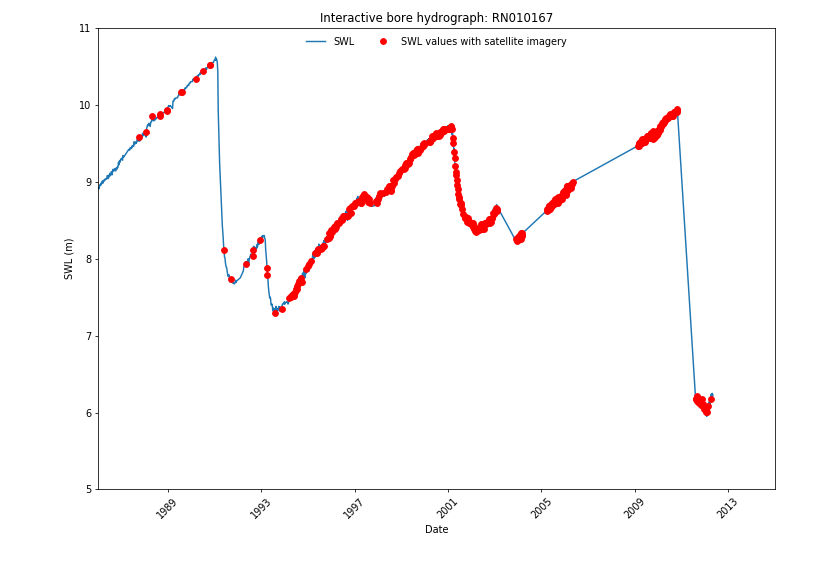

In [43]:
##create plot of flow over measurement period
#Interactive widget
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global time_int, discharge_int, devent
    devent = event
    time_int = event.xdata
    discharge_int= event.ydata
    time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

#plot setup 
#fig = plt.figure(figsize=(10,10))
fig = plt.figure(figsize=(11.69,8.27))
fig.canvas.mpl_connect('button_press_event', callback)
plt.title('Interactive bore hydrograph: ' + bore_of_interest )
plt.show()
display(w)

#plot
matplotlib.pyplot.plot_date(all_dates,all_data['Result (m)'], '-', label= 'SWL')
matplotlib.pyplot.plot_date(subset_dates, subset_data['Result (m)'], 'ro', label='SWL values with satellite imagery')

#axis details
firstyear = '1986-01-01'
lastyear = '2014-12-30'
plt.axis([firstyear , lastyear ,5, 11], 'tight')
plt.xticks(rotation=45,size=10)
plt.ylabel('SWL (m)')
plt.xlabel('Date')
plt.legend(edgecolor ='none', ncol=2, loc=9)
plt.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.15)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.99)



In [105]:
 #save figure
%cd /g/data/r78/Geohack/Input/4_bore/
plt.savefig('Hydrograph_'+bore_of_interest+'_all.jpg')

/g/data1/r78/Geohack/Input/4_bore


In [106]:
print 'Discharge: ' + str(discharge_int) + ' m3'
print 'Date as int: ' + str(time_int)

Discharge: 9.60519978409 m3
Date as int: 730384.968253


In [107]:
time_slice = matplotlib.dates.num2date(time_int).date()
time_slice=str(time_slice)
time_slice= pd.to_datetime(time_slice, format='%Y-%m-%d')
subset_data['Date'] = pd.to_datetime(subset_data['Date'], format='%Y-%m-%d')
subset_data['difference']=(subset_data['Date'] - time_slice).abs()
time_slice=subset_data.ix[argsort(subset_data['difference'])].Date
time_slice= (list(time_slice)[0])
time_slice= str(time_slice)
time_slice=datetime.datetime.strptime(time_slice,'%Y-%m-%d  %H:%M:%S')
time_slice_actual=time_slice
time_slice_t1=time_slice_actual+datetime.timedelta(days=-3)
time_slice_t2=time_slice_actual+datetime.timedelta(days=3)

# #Discharge
# # discharge_title= subset_data.ix[argsort(subset_data['difference'])].'Result (m)'
# # discharge_title= (list(discharge_title)[0])
# # discharge_title= str(discharge_title)
# # discharge_title2= float(discharge_title)
# # discharge_title2=str("{0:.2f}".format(discharge_title2))

# #Percentage exceedance
# perexc_title= subset_data.ix[argsort(subset_data['difference'])].perexc
# perexc_title= (list(perexc_title)[0])
# perexc_title= str(perexc_title)
# perexc_title2= float(perexc_title)
# perexc_title2=str("{0:.2f}".format(perexc_title2))


#Satellite
satellite_type=subset_data.ix[argsort(subset_data['difference'])]
satellite_type=satellite_type['product']
satellite_type= (list(satellite_type)[0])
satellite_type= str(satellite_type)
satellite_type=  satellite_type.replace('pq','nbar')


print 'Time 1:' +str(time_slice_t1)
print 'Actual observation date: ' +str(time_slice_actual)
print 'Time 2: ' +str(time_slice_t2)
# print 'Discharge: ' +str(discharge_title2) +' m3'
#print 'Percent exceedance: '+ str(perexc_title2) + '%'
print 'Product: '+ str(satellite_type)


Time 1:2000-09-22 01:30:00
Actual observation date: 2000-09-25 01:30:00
Time 2: 2000-09-28 01:30:00
Product: ls7_nbar_albers


In [108]:
#This will work for time series that correspond with sensor1
rgb = nbar_clean.sel(time =time_slice, method = 'nearest').to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled2 = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


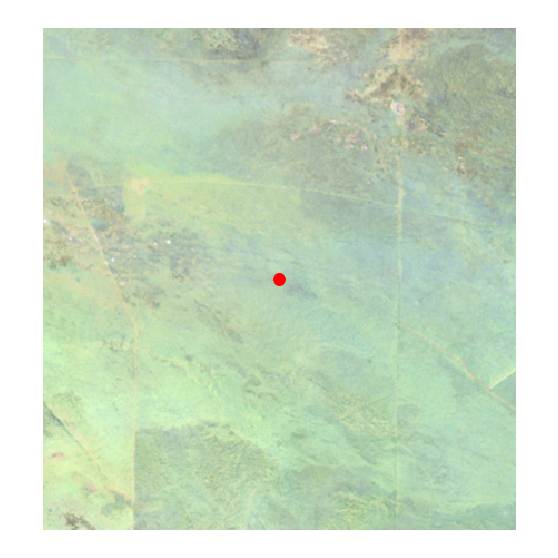

In [109]:
#This image shows the time slice of choice and the location of the time series 
fig = plt.figure(figsize =(8,8))
#plt.title('Gauge: '+gauge_of_interest +'    Date: '+str(time_slice_actual)[0:-9]  + '    Discharge: ' + discharge_title2+' $m^3$ $day^{-1}$' +
#          '   Percentage exceedance: '+ str(perexc_title2) + '%', size=10)
plt.scatter(x = [sg_x], y = [sg_y], c= 'r', marker = 'o', s=150)
plt.imshow(scaled2, interpolation = 'nearest',
           extent=[scaled2.coords['x'].min(), scaled2.coords['x'].max(), 
                  scaled2.coords['y'].min(), scaled2.coords['y'].max()])
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.99)
#remove axis 
plt.axis('off')

plt.show()

In [76]:
#save figure
%cd /g/data/r78/Geohack/Input/4_bore/
plt.savefig('Hydrograph_'+ str(time_slice_actual)[0:-9] + '_' + bore_of_interest+'.jpg')

/g/data1/r78/Geohack/Input/4_bore


# Creation of large image

In [110]:
start_of_epoch = time_slice_t1.strftime("%Y %m, %d")
end_of_epoch = time_slice_t2.strftime("%Y %m, %d")

query2 = {
    'time': (start_of_epoch, end_of_epoch),
}
bands_of_interest = [#'blue',
                     'green',
                     #'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest, # out sensors that aren't relevant for the time period
lat_max = sg_lat+ 0.6
lat_min = sg_lat- 0.6
lon_max = sg_lon+ 0.15
lon_min = sg_lon- 0.8

query2['x'] = (lon_min, lon_max)
query2['y'] = (lat_max, lat_min)
query2['crs'] = 'EPSG:4326'

In [111]:
"""
    'ls8', #May 2013 to present
    'ls7', #1999 to April 2003 (after this it'll have venetian blind artefacts caused by SLC off)
    'ls5' #1987 to 1999 and then from April 2003 to 2011, """
    
image_of_interest = dc.load(product= satellite_type, group_by='solar_day', measurements = bands_of_interest,  **query2)


In [112]:
image_of_interest

<xarray.Dataset>
Dimensions:  (time: 1, x: 4038, y: 5390)
Coordinates:
  * time     (time) datetime64[ns] 2000-09-25T00:56:41.500000
  * y        (y) float64 -2.056e+06 -2.056e+06 -2.056e+06 -2.056e+06 ...
  * x        (x) float64 1.309e+05 1.309e+05 1.31e+05 1.31e+05 1.31e+05 ...
Data variables:
    green    (time, y, x) int16 1012 1050 1050 1031 1069 1088 1069 1088 1088 ...
    nir      (time, y, x) int16 2656 2619 2656 2731 2731 2769 2806 2806 2769 ...
    swir1    (time, y, x) int16 3003 2937 3068 3155 3221 3242 3221 3177 3155 ...
Attributes:
    crs: EPSG:3577

In [113]:
rgb = image_of_interest.to_array(dim='color').sel(color=['swir1','nir', 'green']).squeeze().transpose('y', 'x', 'color')

fake_saturation = 6000
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


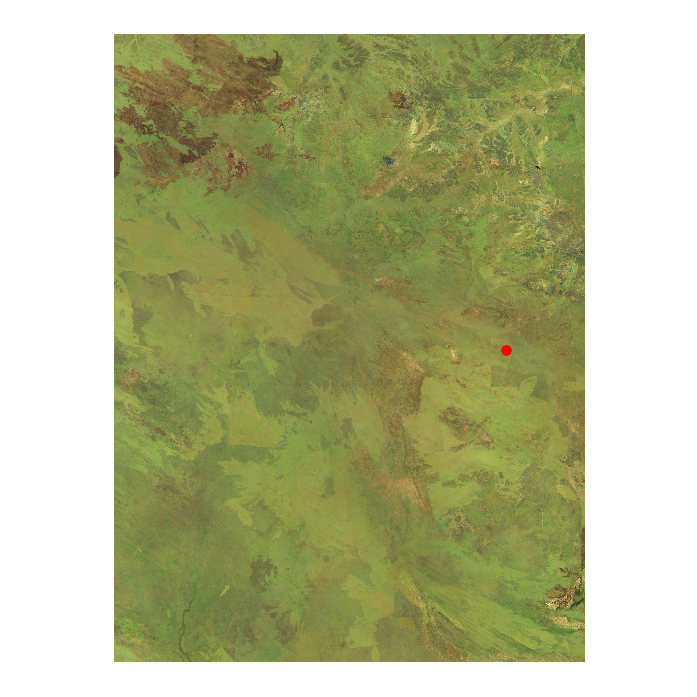

(130912.5, 231837.5, -2190912.5, -2056187.5)

In [114]:
##Create large image

#fig = plt.figure(figsize =(21,21))
fig = plt.figure(figsize =(10,10))

#plt.title('Date: '+str(time_slice_actual)[0:-9]  + '    Flow: ' + discharge_title2+' $m^3$ $day^{-1}$',size=26)

#plt.title('Gauge: '+gauge_of_interest +'    Date: '+str(time_slice_actual)[0:-9]  + '    Discharge: ' + discharge_title2+' $m^3$ $day^{-1}$' +
#          '   Percentage exceedance: '+ str(perexc_title2) + '%', size=22)

#plot imagery and add stream gauging location as marker
plt.scatter(x = [sg_x], y = [sg_y], c= 'r', marker = 'o', s=100)

plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                  scaled.coords['y'].min(), scaled.coords['y'].max()])
#reformat
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.99)

#remove axis 
plt.axis('off')



In [115]:
#save figure
%cd /g/data/r78/Geohack/Input/4_bore/
plt.savefig('Hydrograph_'+ str(time_slice_actual)[0:-9] +'_'+ bore_of_interest+'_large.jpg')

/g/data1/r78/Geohack/Input/4_bore


# Save as netcdf

In [ ]:
#get the original nbar dataset attributes (crs)
#set up variable attributes to hold the attributes
attrs = image_of_interest
#get the band info
bands = attrs.data_vars.keys()
print bands
for i in bands:
    #drop band data, retaining just the attributes
    attrs =attrs.drop(i)
#set up new variable called ndvi_var, and assign attributes to it in a dictionary
image_var = {'scaled':''}
image_output = attrs.assign(**image_var)
image_output['scaled'] = scaled
print image_output
image_output2 = image_output.scaled.to_dataset(dim='color')
#print image_output
image_output2.attrs['crs'] = image_output.crs


In [ ]:
## create net cdf
outfile = '/g/data/r78/ext547/Output/netcdf/'+ str(time_slice_actual)[0:-9] +'.nc'
write_dataset_to_netcdf(image_output2,  variable_params={'scaled': {'zlib':True}}, filename=outfile)
print 'wrote: '+outfile+' to netcdf'

In [ ]:
# DEFAULT_PROFILE = {
#    'blockxsize': 256,
#    'blockysize': 256,
#    'compress': 'lzw',
#    'driver': 'GTiff',
#    'interleave': 'band',
#    'nodata': 0.0,
#    'photometric': 'RGBA',
#    'tiled': True}


# #this function definition comes from CK's Principal_Component_Analysis_AGDC_looped notebook, and before that from AGDC recipes.
# def write_geotiff(filename, dataset, time_index=None, profile_override=None):
#     """
#     Write an xarray dataset to a geotiff
#     :attr bands: ordered list of dataset names
#     :attr time_index: time index to write to file
#     :attr dataset: xarray dataset containing multiple bands to write to file
#     :attr profile_override: option dict, overrides rasterio file creation options.
#     """
#     profile_override = profile_override or {}

#     dtypes = {val.dtype for val in dataset.data_vars.values()}
#     assert len(dtypes) == 1  # Check for multiple dtypes

# #     profile = DEFAULT_PROFILE.copy()
# #     profile.update({
# #         'width': dataset.dims['x'],
# #         'height': dataset.dims['y'],
#         #'affine': dataset.affine, #changed following line 17/03/17 due to changes in AGDC I think
#         'affine': dataset.affine,
#         'crs': dataset.crs.crs_str,
#         #'crs': dataset.crs,
#         'count': len(dataset.data_vars),
#         'dtype': str(dtypes.pop())
#     })
#     profile.update(profile_override)

#     with rasterio.open(filename, 'w', **profile) as dest:
#         for bandnum, data in enumerate(dataset.data_vars.values(), start=1):
#             #dest.write(data.isel(time=time_index).data, bandnum)
#             dest.write(data, bandnum)
#             print ('Done')

In [ ]:
# outfile = '/g/data/r78/ext547/Working/' + 'test' + '.tiff'
# image_output2.attrs['crs'] = image_output.crs
# write_geotiff(outfile, image_output2)
# print 'tiff writing complete'

In [ ]:

#est_output2.y[1] - test_output2.y[0]

In [ ]:
#%cd /g/data/r78/ext547/Working/
#!ls

In [ ]:
#!gdalinfo test.tiff

In [ ]:
# def pq_fuser(dest, src):
#     valid_bit = 8
#     valid_val = (1 << valid_bit)
#     no_data_dest_mask = ~(dest & valid_val).astype(bool)
#     np.copyto(dest, src, where=no_data_dest_mask)
#     both_data_mask = (valid_val & dest & src).astype(bool)
#     np.copyto(dest, src & dest, where=both_data_mask)
# indexers = {'time':('1991', '1992'), 'x':(lon_min, lon_max),   'y':(lat_min, lat_max), 'group_by':'solar_day'}
# data = dc.load(product='ls5_nbar_albers', **indexers)
# pq = dc.load(product='ls5_pq_albers', fuse_func=pq_fuser, **indexers)
# mask_clear = pq['pixelquality'] & 15871 == 15871    # 15871 - This is a cloud free bits that includes land and sea bits
# data = data.where(mask_clear)

# from datacube.storage import masking
# pq = dc.load(product='ls5_pq_albers', x=(lon_min, lon_max), y=(lat_min, lat_max), 
#              time=('1991', '1992'), group_by='solar_day')
# # Make a mask for clouds
# cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality
# # Find where at least 75% of the image is cloud free
# mostly_cloud_free = cloud_free.mean(dim=('x','y')) > 0.75
# # return only the NDVI times where there are no clouds
# # dropna - return object with labels on given axis omitted where any/all the data are missing
# #mostly_good_ndvi = ndvi.where(mostly_cloud_free).dropna('time', how='all')
# #mostly_cloud_free.plot(col='time', col_wrap=3)
# mostly_cloud_free = cloud_free.sum(dim=('x','y')) > (0.75 * data.green.size / data.time.size)
# test = data.where(mostly_cloud_free).dropna('time', how='all')

# print test.isel(time =1)